In [18]:
using Pkg, Random
using Dates
using PyPlot, Logging
import Base.show, Base.copy

struct Node
    id::Int16
    x::Float32
    y::Float32
end

function show(io::IO, n::Node)
    print(string("Node:", n.id))
end

show (generic function with 292 methods)

In [19]:
mutable struct Firefly
    path::Array{Node}
    cost::Float32
end

function show(io::IO, n::Firefly)
    print(string("Firefly:", n.cost, " "))
end

copy(s::Firefly) = Firefly(s.path, s.cost)

copy (generic function with 84 methods)

In [20]:
function arc_distance(f1::Firefly, f2::Firefly)::Int
    """Calculates the arc distance between two firefly paths.
    Example:
        Firefly i -> 1 2 4 6 3 5 7
        Firefly j -> 1 2 4 3 5 7 6 
        1-2, 2-4, 3-5, 5-7 arcs in firefly i are also presented
        in firefly j. But 4-6, 6-3 arcs are missing in
        firefly j. so the arc distance between firefly i
        and firefly j is 2 here.
    """
    missmatched_pair_counts = 0
    f1_pairs = zip(f1.path[1:end-1], f1.path[2:end])
    f2_pairs = zip(f2.path[1:end-1], f2.path[2:end])

    for f1_pair in f1_pairs
        if f1_pair ∉ f2_pairs missmatched_pair_counts += 1 end
    end

    return missmatched_pair_counts
end


arc_distance (generic function with 1 method)

In [21]:
function attractiveness(source_node::Firefly, destination_node::Firefly, λ::Float32)::Float32
    """Firefly’s attractiveness is proportional to the light
    intensity seen by adjacent fireflies, we can now define the
    attractiveness β of a firefly depending on distance between
    two fireflies.
    """
    β = source_node.cost
    r, _ = hamming_distance(source_node, destination_node)
    return β * exp(-λ ^ (r^2))
end

attractiveness (generic function with 1 method)

In [22]:
function create_distance_matrix(nodes::Array{Node})
    """Creates and returns the matrix of distances between given nodes.
    Uses euclidean_distance function to calculate distance.
    """
    node_num = length(nodes)
    result_matrix = zeros(node_num, node_num)

    for n1 in nodes
        for n2 in nodes
            result_matrix[n1.id,n2.id] = haversine_distance(n1, n2)
        end
    end
    return result_matrix
end

create_distance_matrix (generic function with 1 method)

In [23]:
function generate_mutated_fireflies(firefly::Firefly, distance_matrix, r::Int, k::Int)::Array{Firefly}
    """Generates mutated fireflies using inversion_mutation function.
    Returns the new generated firefly array.
    """
    return [inversion_mutation(copy(firefly), distance_matrix, r) for _ in 1:k]
end

generate_mutated_fireflies (generic function with 1 method)

In [24]:
function hamming_distance(firefly_1::Firefly, firefly_2::Firefly)
    """Calculates the hamming distance between two fireflies.
    """
    dist = 0
    dist_info = []
    for (i, n) in enumerate(firefly_1.path)
        if n.id != firefly_2.path[i].id
            dist += 1
            push!(dist_info, true)
        else
            push!(dist_info, false)
        end
    end
    return dist, dist_info
end

hamming_distance (generic function with 1 method)

In [25]:
function haversine_distance(n1::Node, n2::Node)::Float32
    #converting decimal degree to radians
    lat1=n1.y
    long1=n1.x
    lat2=n2.y
    long2=n2.x
    lat1,long1,lat2,long2=map(deg2rad,[lat1,long1,lat2,long2])
    
    # Using Haversine formula for distance calculation
    dlat=lat2-lat1
    dlong=long2-long1
    a=sin(dlat/2)^2 + cos(lat1) * cos(lat2) * sin(dlong/2)^2
    c=2 * asin(sqrt(a))
    r=6371 #radius of earth in km
    return c*r
end

haversine_distance (generic function with 1 method)

In [26]:
function init_firefly_paths(fireflies::Array{Firefly}, distance_matrix)
    """Initializes random paths for the given firefly array.
    """
    println("inside init_firefly_paths")
    for f in fireflies
        shuffle!(f.path)
        f.cost = path_cost(f, distance_matrix)
    end
end

init_firefly_paths (generic function with 1 method)

In [27]:
function inversion_mutation(firefly::Firefly, distance_matrix, r::Int)::Firefly
    """Reverses the random part of given firefly path with
    given difference.
    """
    length_of_mutation = rand(2:r);
    max_len = length(firefly.path)-length_of_mutation
    index1 = rand(1:max_len)
    index2 = index1 + length_of_mutation
    mutated_path = reverse(firefly.path, index1, index2)
    new_f = copy(firefly)
    new_f.path = mutated_path
    new_f.cost = path_cost(new_f, distance_matrix)
    return new_f
end

inversion_mutation (generic function with 1 method)

In [28]:
function light_intensity(source_node::Firefly, destination_node::Firefly, λ::Float32)::Float32
    """Calculates the light intensity for the source firefly.
    """
    I_0 = source_node.cost
    r, _ = hamming_distance(source_node, destination_node)
    return I_0 * ℯ ^ (-λ * (r^2))
end

light_intensity (generic function with 1 method)

In [29]:
function move_firefly(f1::Firefly, f2::Firefly, r::Int)
    """Moving f1 to f2 less than r swap operations.
    """
    number_of_swaps = Int(ceil(rand() * (r-2) ))
    d, d_info = hamming_distance(f1, f2)

    while number_of_swaps > 0
        d, d_info = hamming_distance(f1, f2)
        random_index = rand([i for i in 1:length(d_info) if d_info[i]])
        value_to_copy = f2.path[random_index]
        index_to_move = findfirst(x -> x==value_to_copy, f1.path)

        if number_of_swaps == 1 && f1.path[index_to_move] == f2.path[random_index] && f1.path[random_index] == f2.path[index_to_move]
            break
        end

        f1.path[random_index], f1.path[index_to_move] = f1.path[index_to_move], f1.path[random_index]
        # println("swapped! ", f1.path[random_index], " -- ", f1.path[index_to_move])
        if f1.path[index_to_move] == f2.path[index_to_move] number_of_swaps -= 1 end
        number_of_swaps -= 1
    end
end

move_firefly (generic function with 1 method)

In [30]:
function path_cost(firefly::Firefly, distance_matrix)::Float32
    """Calculates the total path cost from given distance matrix.
    """
    path = firefly.path
    path_len = length(path) - 1
    p_cost = distance_matrix[path[end].id, path[1].id]
    for i in range(1, length=path_len)
        p_cost +=  distance_matrix[path[i].id, path[i+1].id]
    end

    return p_cost
end

path_cost (generic function with 1 method)

In [31]:
function read_nodes(path::String)::Array{Node}
    """Reading nodes from giving file path.
    """
    nodes = Node[]
    open(path) do f
        is_coords = false
        for line in eachline(f)
            if line == "EOF"
                break
            end
            if line[1] == '1' 
                is_coords = true
            end
            if is_coords
                line_vals = split(line)
                id = parse(Int16, line_vals[1])
                x_coord = parse(Float32, line_vals[2])
                y_coord = parse(Float32, line_vals[3])
                push!(nodes, Node(id, x_coord, y_coord))
            end
        end
    end
    return nodes
end

read_nodes (generic function with 1 method)

In [43]:
function main()
    
    #now = string(Dates.now())

    file_name = "cluster1"
    if file_name != nothing
        println("Reading from: ", file_name)
        nodes = read_nodes(file_name)
        distance_matrix = create_distance_matrix(nodes)
    end

    # Checking if logs direcitory is available!
    # If is not create one!
    if !isdir("logs") mkdir("logs"); end

    if '/' in file_name
        tsp_file_name = split(file_name, "/")[end]
        io_log = open("logs/$tsp_file_name.txt", "w+")
    else
        tsp_file_name = file_name
        io_log = open("logs/$tsp_file_name.txt", "w+")
    end

    # Setting Logger!
    logger = SimpleLogger(io_log)
    global_logger(logger)

    # Setting hyperparameters!
    LIGHT_ABSORPTION_COEFF = 0.2
    ATTRACTION_COEFF = 1
    ITERATION_NUMBER = 100
    POPULATION_NUMBER = 150
    NUMBER_OF_MUTATION = 10

    # Main firefly algorithm
    bests = []
    pop = [Firefly(copy(nodes), -1.0) for _ in 1:POPULATION_NUMBER]
    init_firefly_paths(pop, distance_matrix)
    println(length(pop), " Sized population created!")
    for t in 1:ITERATION_NUMBER
        new_pop = []
        for f1 in pop
            for f2 in pop
                if f1.cost < f2.cost 
                    mutated_f1s = generate_mutated_fireflies(f2, distance_matrix, arc_distance(f1, f2), NUMBER_OF_MUTATION)
                    new_pop = [new_pop ; mutated_f1s]
                    push!(new_pop, f2)
                end
            end
        end
        [push!(pop, n) for n in new_pop]
        sorted_pop = sort!(pop, by=p->p.cost)
        while length(pop) != POPULATION_NUMBER
            pop!(pop)
        end
        push!(bests, sorted_pop[1])
        current_best_cost = copy(bests[end].cost)
        now = string(Dates.now())
        println("Step:",t, " - Best ", bests[end])
        @info("Step:$t, Population Size:$POPULATION_NUMBER, Mutation Number:$NUMBER_OF_MUTATION, Date:$now",
              current_best_cost)
    end

    close(io_log)

    # Checking if graphs direcitory is available for saving graphs!
    # If is not create one!
    if !isdir("graphs") mkdir("graphs"); end

    # Plotting and printing the best solutions.
    best = sort(pop, by=p->p.cost)[1]
    best_x = [n.x for n in best.path]
    best_y = [n.y for n in best.path]
    best_id= [n.id for n in best.path]
    best_cost = best.cost
    plot(best_x, best_y, "-")
    x = [n.x for n in nodes]
    y = [n.y for n in nodes]
    plot(x, y, "ro", markersize=2.0)
    xlabel("X Dimension")
    ylabel("Y Dimension")
    title("Firefly Cost: $best_cost", fontsize=10)
    suptitle("File: $file_name", fontweight="bold")
    fig_name = "graphs/best_firefly_path_$tsp_file_name-cost_$best_cost.png"
    savefig(fig_name)
    println("Saved figure:",fig_name)
    clf()

    x_cost = [b.cost for b in bests]
    plot(x_cost)
    grid(true)
    ylabel("Path Cost")
    xlabel("Iteration Number")
    title("Firefly Iteration Graphic", fontsize=12)
    fig_name = "graphs/iteration_$tsp_file_name-cost_$best_cost.png"
    savefig(fig_name)
    println("Saved figure:",fig_name)
    return z=[best_id, best_x, best_y]
end

main (generic function with 1 method)

Reading from: cluster1
inside init_firefly_paths
150 Sized population created!
Step:1 - Best Firefly:3011.059 
Step:2 - Best Firefly:2751.9478 
Step:3 - Best Firefly:2550.2651 
Step:4 - Best Firefly:2323.3684 
Step:5 - Best Firefly:2323.3684 
Step:6 - Best Firefly:2323.3684 
Step:7 - Best Firefly:2323.3684 
Step:8 - Best Firefly:2323.3684 
Step:9 - Best Firefly:2323.3684 
Step:10 - Best Firefly:2323.3684 
Step:11 - Best Firefly:2323.3684 
Step:12 - Best Firefly:2323.3684 
Step:13 - Best Firefly:2323.3684 
Step:14 - Best Firefly:2323.3684 
Step:15 - Best Firefly:2323.3684 
Step:16 - Best Firefly:2323.3684 
Step:17 - Best Firefly:2323.3684 
Step:18 - Best Firefly:2323.3684 
Step:19 - Best Firefly:2323.3684 
Step:20 - Best Firefly:2323.3684 
Step:21 - Best Firefly:2323.3684 
Step:22 - Best Firefly:2323.3684 
Step:23 - Best Firefly:2323.3684 
Step:24 - Best Firefly:2323.3684 
Step:25 - Best Firefly:2323.3684 
Step:26 - Best Firefly:2323.3684 
Step:27 - Best Firefly:2323.3684 
Step:28 - Bes

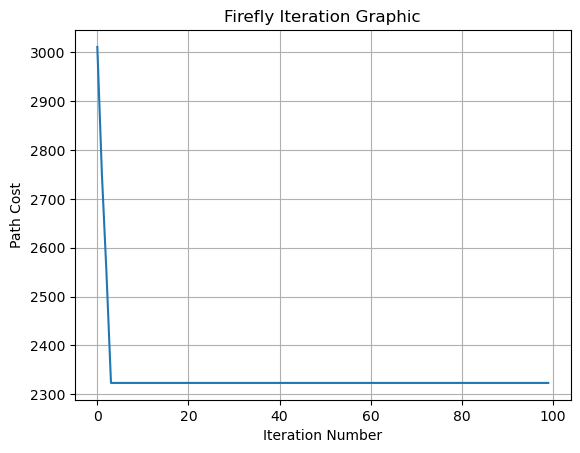


Saved figure:graphs/iteration_cluster1-cost_2323.3684.png


3-element Vector{Vector{Float32}}:
 [10.0, 8.0, 4.0, 2.0, 9.0, 1.0, 7.0, 11.0, 13.0, 3.0, 6.0, 15.0, 12.0, 5.0, 14.0]
 [73.32061, 73.00594, 73.31496, 74.640816, 75.839066, 74.638664, 75.78787, 75.78934, 75.78611, 77.40289, 75.85859, 75.776436, 75.04031, 72.683334, 73.690506]
 [25.775126, 26.26841, 28.017624, 25.34707, 25.182545, 26.452103, 26.913313, 26.884682, 26.168673, 23.254688, 22.717735, 23.182386, 23.330332, 23.216667, 24.57951]

In [44]:
main()